BASE CASE: all images are classified using transfer learning. The pretrained ResNet 50 was used as a based for transfer learning as the fully connected layer was modified.

code was based off template from : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?form=MG0AV3


Processing dataset: Dataset1 from D:\git\FYP\Python\TwoStage\data\Dataset1\Pandora7k_split_70

Training with configuration: SGD_basic
Epoch 0/49
----------
Train Loss: 2.3820 Acc: 0.1596 Precision: 0.1622 Recall: 0.1596 F1: 0.1303
New best accuracy: 0.2320 at epoch 1
New best model found at epoch 1, saving the entire model.
Val Loss: 2.3111 Acc: 0.2320 Precision: 0.2021 Recall: 0.2320 F1: 0.1869

Epoch 1/49
----------
Train Loss: 2.2399 Acc: 0.2857 Precision: 0.2694 Recall: 0.2857 F1: 0.2438
Val Loss: 2.2082 Acc: 0.2260 Precision: 0.3340 Recall: 0.2260 F1: 0.1869

Epoch 2/49
----------
Train Loss: 2.1429 Acc: 0.3359 Precision: 0.3414 Recall: 0.3359 F1: 0.2965
New best accuracy: 0.3074 at epoch 3
New best model found at epoch 3, saving the entire model.
Val Loss: 2.1200 Acc: 0.3074 Precision: 0.3609 Recall: 0.3074 F1: 0.2599

Epoch 3/49
----------
Train Loss: 2.0518 Acc: 0.3863 Precision: 0.3643 Recall: 0.3863 F1: 0.3387
New best accuracy: 0.3481 at epoch 4
New best model found at epoc

C:\Users\persad\AppData\Local\Temp\ipykernel_27792\764964146.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name)


Predictions and metrics saved to Experiments\Case_SGD_basic\Dataset1\Validation\predictions.xlsx.


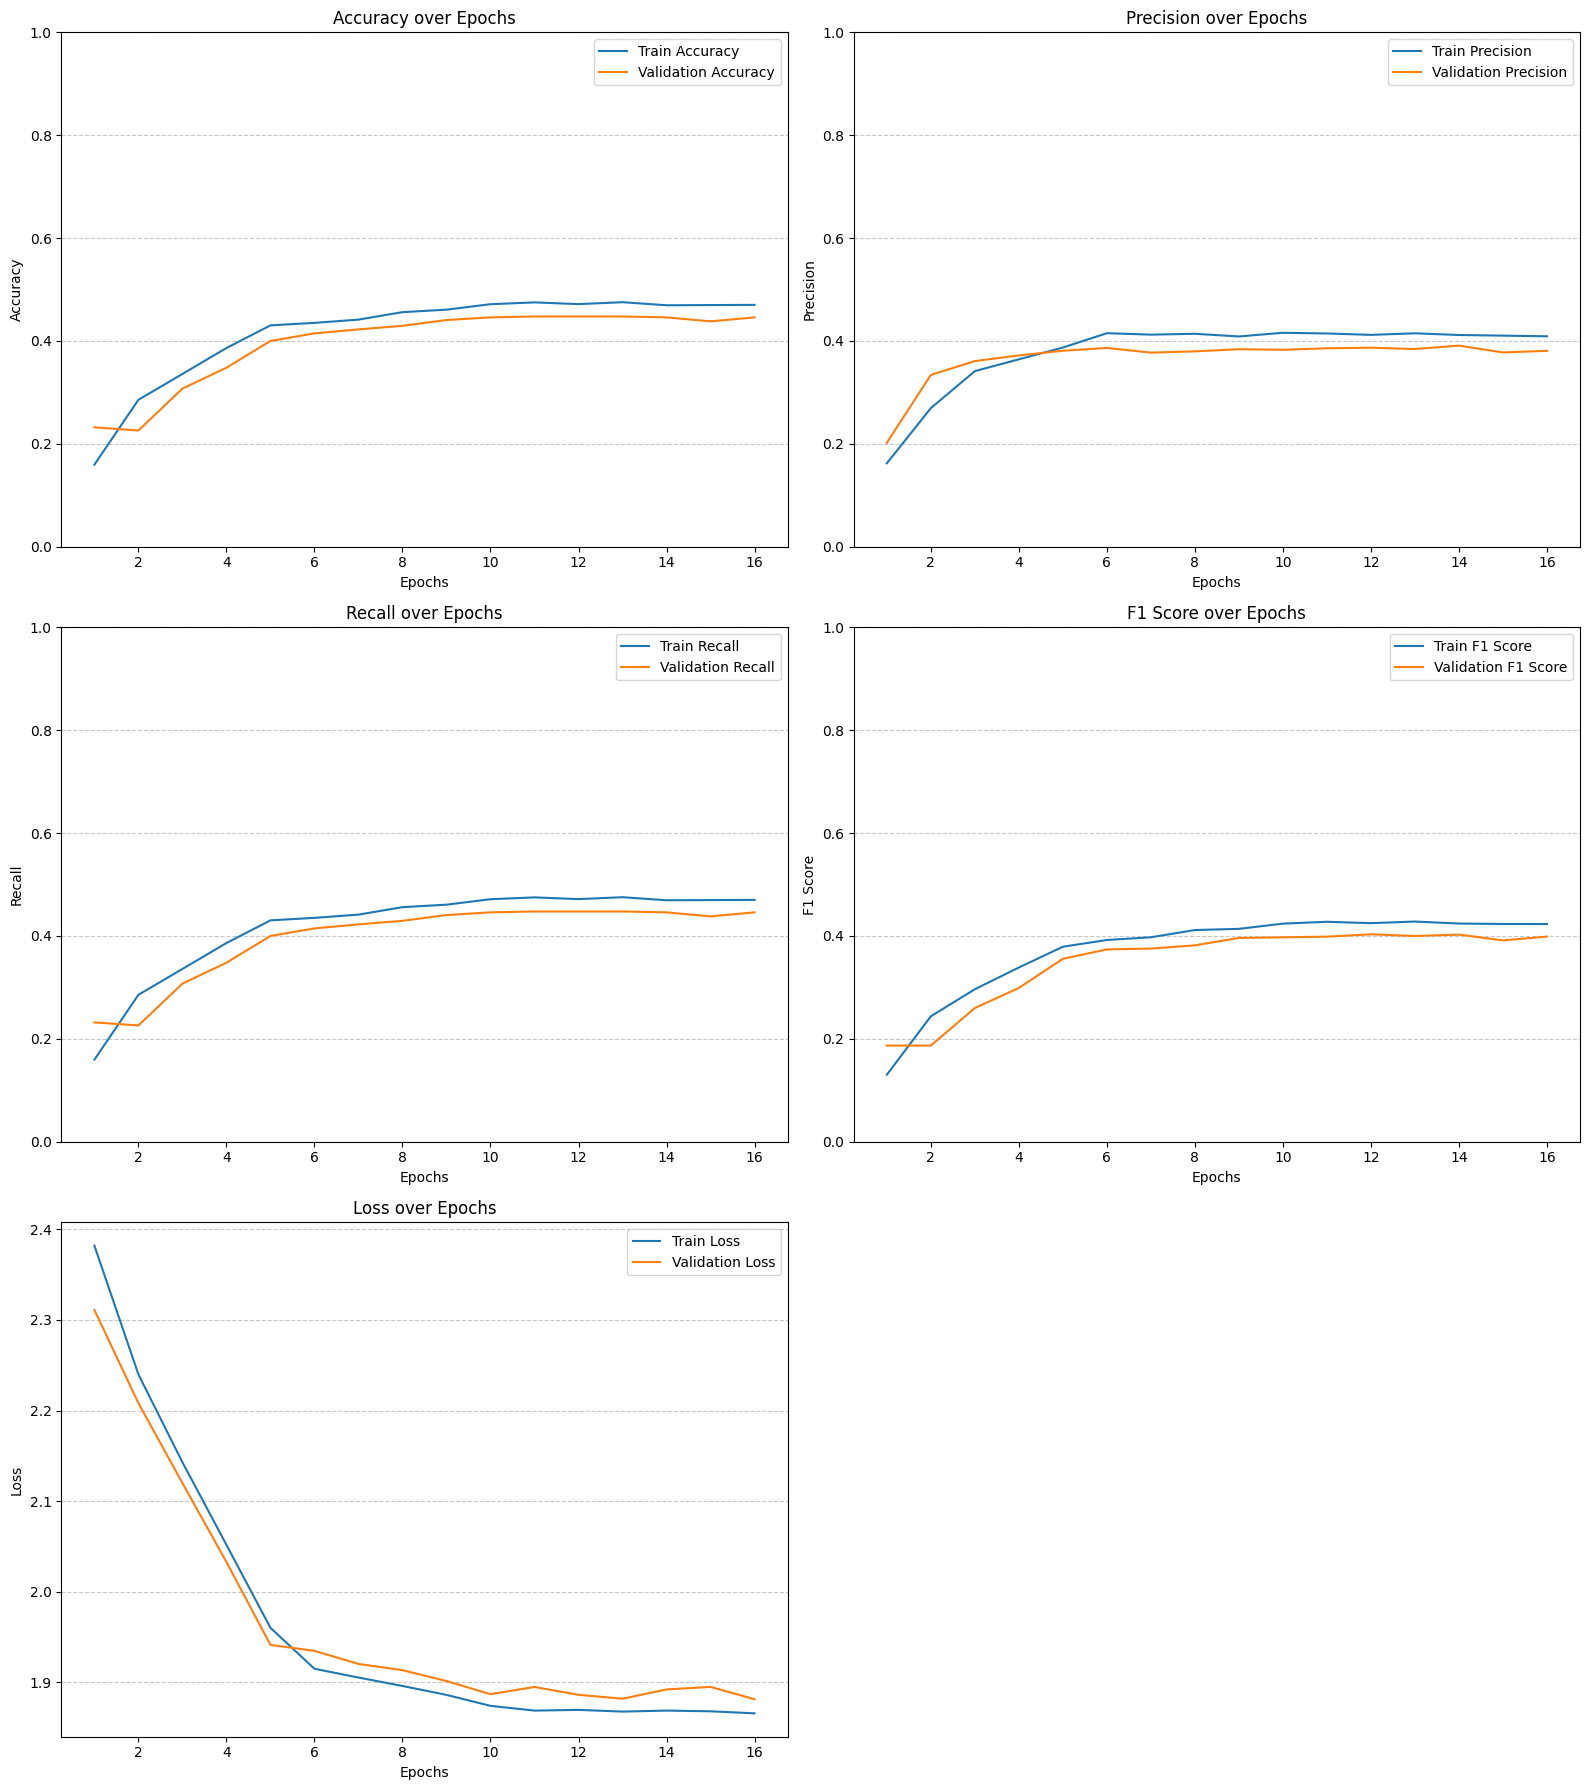

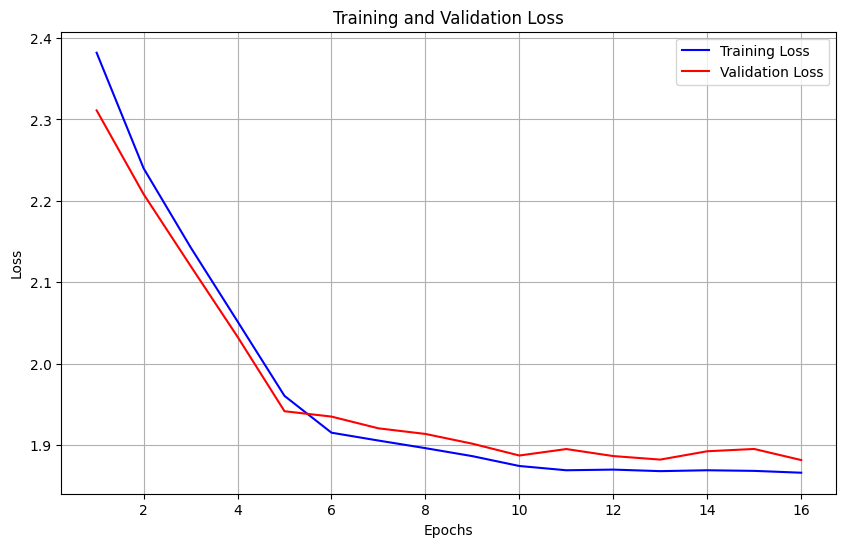

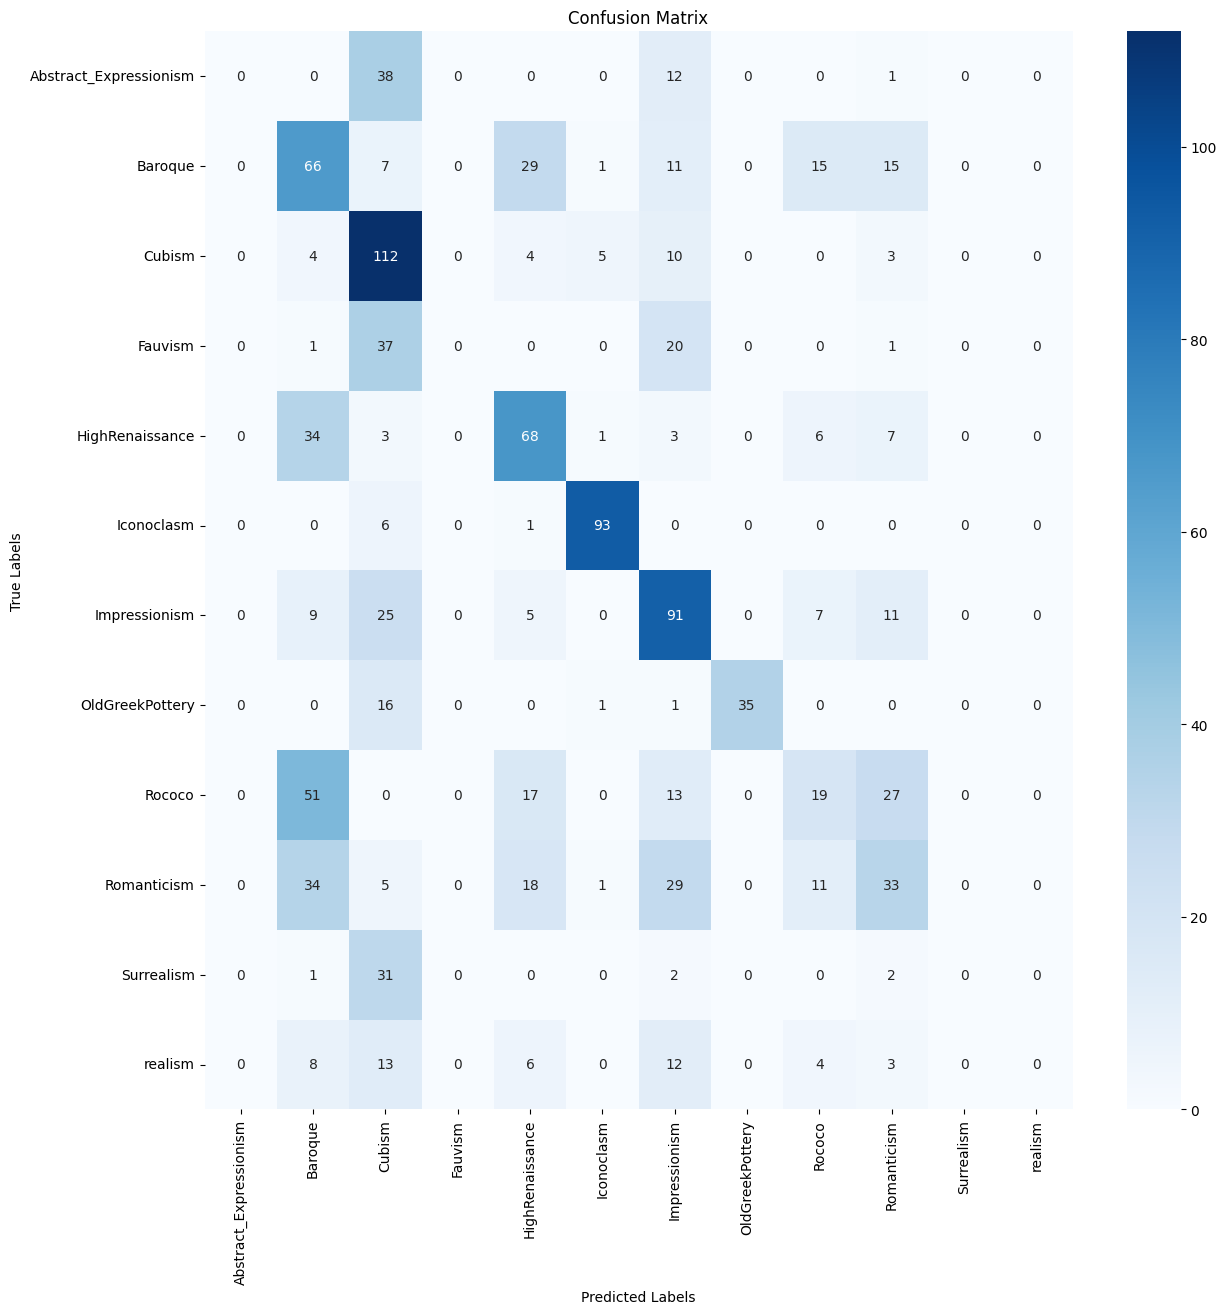

<Figure size 1400x1000 with 0 Axes>

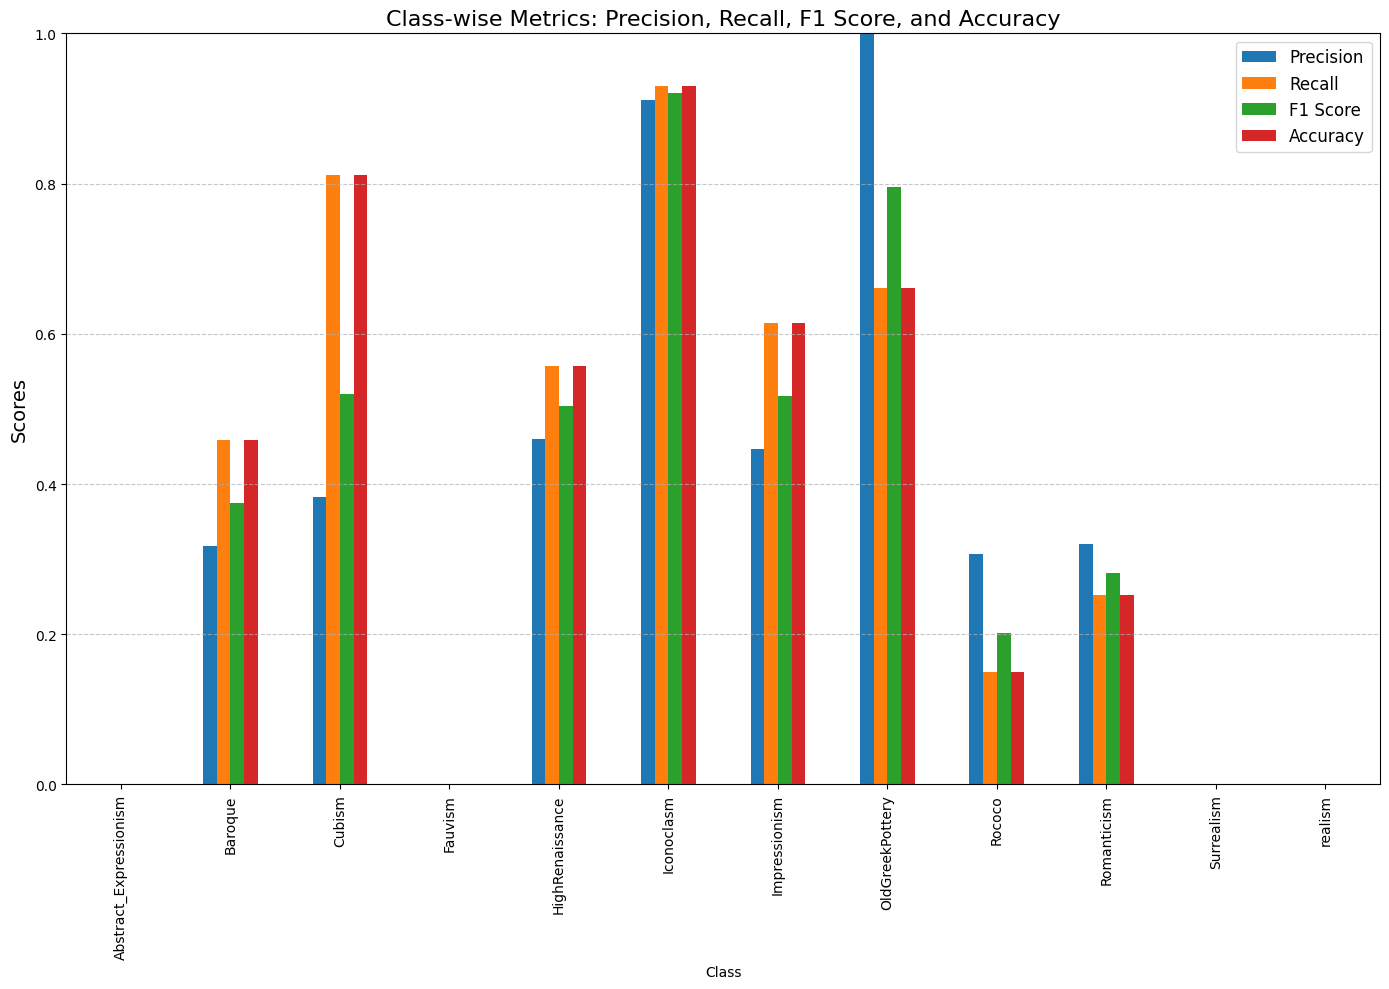

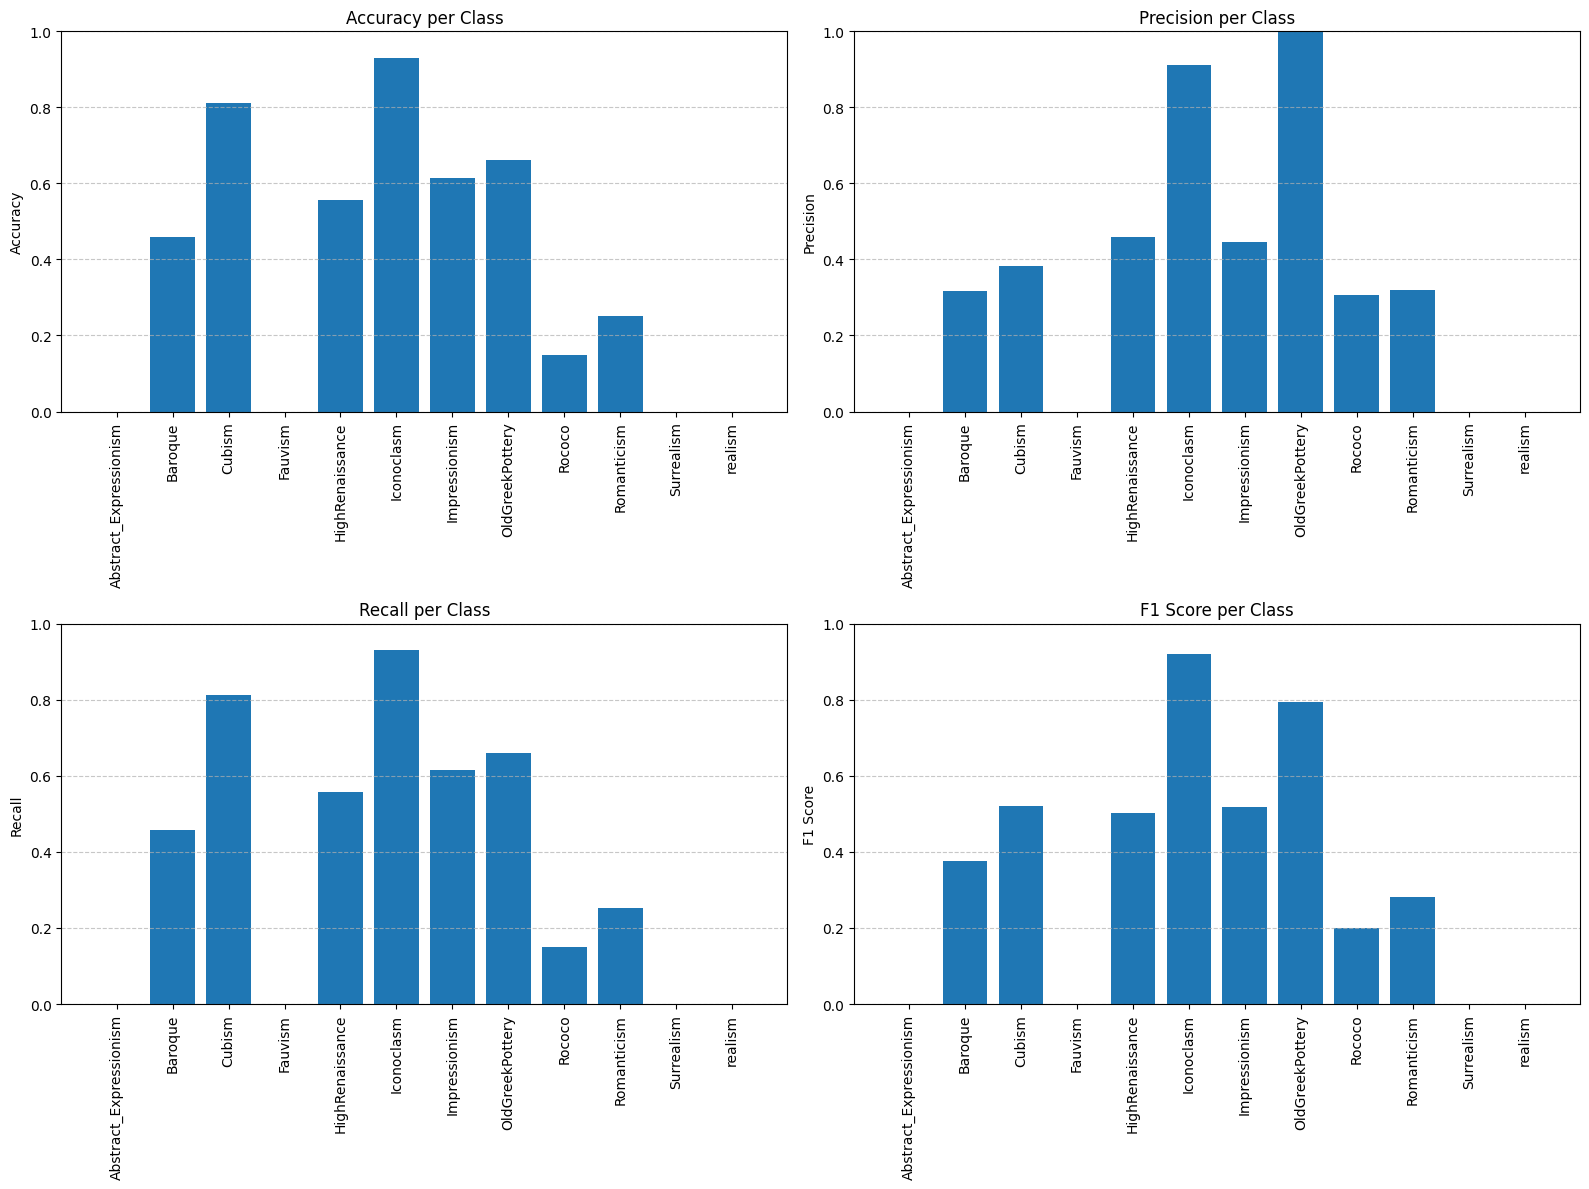

Per-class metrics saved to Experiments\Case_SGD_basic\Dataset1\Validation\per_class_metrics.csv

All experiment results have been summarized in Experiments\all_experiments_summary.xlsx


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter

cudnn.benchmark = True
plt.ion() 

# Define datasets
datasets_info = [
    # {
    #     "name": "Sample",
    #     "path": r"D:\git\FYP\Python\understanding\sample"
    # },
    {
        "name": "Dataset1",
        "path": r"D:\git\FYP\Python\TwoStage\data\Dataset1\Pandora7k_split_70"
    },
    # {
    #     "name": "Dataset2",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset2\Pandora_18k_split_70"
    # },
    # {
    #     "name": "Dataset3",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset3\Dataset3_Equal_70split"
    # },
    # {
    #     "name": "Dataset4",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset4\BalancedWikiart_70_split"
    # },
    # {
    #     "name": "Dataset5",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset5\Dataset5_70_split"
    # }
    
]

# Define optimizer and scheduler configurations
configurations = [
    {
        "name": "SGD_basic",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5)
    },
    # {
    #     "name": "SGD_gamma",
    #     "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001),
    #     "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    # },
    # {
    #     "name": "SGD_momentum_gamma",
    #     "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
    #     "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    # },
    # {
    #     "name": "SGD_momentum_gamma_lr0.0001",
    #     "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.0001, momentum=0.9),
    #     "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    # },
    # {
    #     "name": "SGD_momentum_gamma_lr0.01",
    #     "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    #     "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    # }
]

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

results = []

# Function to train/validate a model for a single epoch
def run_epoch(model, dataloader, criterion, optimizer=None, scheduler=None, phase='train'):
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities
    image_names = []  # To store image names
    
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() if optimizer else None
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # Store probabilities
        image_names.extend([x[0].split("\\")[-1] for x in dataloader.dataset.samples])
    
    if phase == 'train' and scheduler:
        scheduler.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    return epoch_loss, epoch_acc.item(), precision, recall, f1, image_names, all_labels, all_preds, all_probs

# Function to calculate precision, recall, and F1 scores
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return precision, recall, f1

# Function to handle training and validation across epochs
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=50, patience=3, model_name='best_model.pt'):
    best_acc = 0.0
    epochs_no_improve = 0
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'loss': []}  # Added 'loss' key
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'loss': []}    # Added 'loss' key
    best_epoch = 0
    all_image_data = []
    all_image_probs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n{"-"*10}')
        
        # Training and validation phases
        for phase in ['train', 'val']:
            dataloader = dataloaders[phase]
            optimizer_to_use = optimizer if phase == 'train' else None
            epoch_loss, epoch_acc, precision, recall, f1, image_names, true_labels, pred_labels, probs = run_epoch(
                model, dataloader, criterion, optimizer_to_use, scheduler, phase
            )
            
            # Logging metrics
            if phase == 'train':
                train_metrics['accuracy'].append(epoch_acc)
                train_metrics['precision'].append(precision)
                train_metrics['recall'].append(recall)
                train_metrics['f1'].append(f1)
                train_metrics['loss'].append(epoch_loss)  # Store the loss value
            else:
                val_metrics['accuracy'].append(epoch_acc)
                val_metrics['precision'].append(precision)
                val_metrics['recall'].append(recall)
                val_metrics['f1'].append(f1)
                val_metrics['loss'].append(epoch_loss)    # Store the loss value
                
                # Track best accuracy and corresponding epoch
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch + 1
                    print(f"New best accuracy: {best_acc:.4f} at epoch {best_epoch}")

                    epochs_no_improve = 0
                    print(f"New best model found at epoch {best_epoch}, saving the entire model.")
                    torch.save(model, model_name)
                    
                    # Store validation results for best model
                    all_image_data = list(zip(image_names, true_labels, pred_labels))
                    all_image_probs = probs
                else:
                    epochs_no_improve += 1
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                    f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
        
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
        print()
    
    # Load the best saved model
    if os.path.exists(model_name):
        model = torch.load(model_name)
        print(f"Best model loaded from {model_name}.")
    else:
        print("No model saved; returning the last trained model.")
    return model, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc
    return model, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc

# Function to output metrics as a DataFrame
def metrics_to_df(train_metrics, val_metrics, best_epoch):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    metrics_df = pd.DataFrame({
        'Epoch': epochs,
        'Train Loss': train_metrics['loss'],
        'Val Loss': val_metrics['loss'],
        'Train Accuracy': train_metrics['accuracy'],
        'Val Accuracy': val_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Val Precision': val_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Val Recall': val_metrics['recall'],
        'Train F1 Score': train_metrics['f1'],
        'Val F1 Score': val_metrics['f1'],
    })
    metrics_df['Best Epoch'] = best_epoch
    return metrics_df

#Function to save predictions to Excel with class names instead of numerical labels
def save_predictions_to_excel(all_image_data, all_probs, metrics_df, class_names, folder_name='.', filename='model_output.xlsx'):
    # Map numerical class labels to class names
    rows = []
    
    for (image_name, true_class, pred_class), probs in zip(all_image_data, all_probs):
        # Get top 3 predictions and their probabilities
        top3_indices = np.argsort(probs)[::-1][:3]
        top3_classes = [class_names[idx] for idx in top3_indices]
        top3_probs = [probs[idx] for idx in top3_indices]
        
        row = {
            'Image Name': image_name,
            'True Class': class_names[true_class],
            'Predicted Class': class_names[pred_class],
            'Correct Prediction': class_names[true_class] == class_names[pred_class],
            'Top1 Class': top3_classes[0],
            'Top1 Probability': f"{top3_probs[0]:.4f}",
            'Top2 Class': top3_classes[1],
            'Top2 Probability': f"{top3_probs[1]:.4f}",
            'Top3 Class': top3_classes[2],
            'Top3 Probability': f"{top3_probs[2]:.4f}"
        }
        rows.append(row)
    
    predictions_df = pd.DataFrame(rows)
    
    # Create full path for the file
    full_path = os.path.join(folder_name, os.path.basename(filename))
    
    with pd.ExcelWriter(full_path, engine='xlsxwriter') as writer:
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    print(f"Predictions and metrics saved to {full_path}.")

# Define function to create the folder structure
def create_folder_structure(base_dir="Experiments"):
    # Create base directory
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        print(f"Created base directory: {base_dir}")
    
    # Create case directories and subdirectories
    for config in configurations:
        case_dir = os.path.join(base_dir, f"Case_{config['name']}")
        if not os.path.exists(case_dir):
            os.makedirs(case_dir)
            print(f"Created case directory: {case_dir}")
        
        # Create dataset subdirectories
        for dataset in datasets_info:
            dataset_dir = os.path.join(case_dir, dataset["name"])
            validation_dir = os.path.join(dataset_dir, "Validation")
            testing_dir = os.path.join(dataset_dir, "Testing")
            
            for dir_path in [dataset_dir, validation_dir, testing_dir]:
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                    print(f"Created directory: {dir_path}")
    
    return base_dir

def plot_metrics_and_save(train_metrics, val_metrics, output_dir, filename_prefix='metrics'):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    
    # Create a figure with a 3x2 grid of subplots to include loss
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    
    # Plot Accuracy
    axes[0, 0].plot(epochs, train_metrics['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(epochs, val_metrics['accuracy'], label='Validation Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].set_title('Accuracy over Epochs')
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Precision
    axes[0, 1].plot(epochs, train_metrics['precision'], label='Train Precision')
    axes[0, 1].plot(epochs, val_metrics['precision'], label='Validation Precision')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()
    axes[0, 1].set_title('Precision over Epochs')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Recall
    axes[1, 0].plot(epochs, train_metrics['recall'], label='Train Recall')
    axes[1, 0].plot(epochs, val_metrics['recall'], label='Validation Recall')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].set_title('Recall over Epochs')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot F1 Score
    axes[1, 1].plot(epochs, train_metrics['f1'], label='Train F1 Score')
    axes[1, 1].plot(epochs, val_metrics['f1'], label='Validation F1 Score')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].set_title('F1 Score over Epochs')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

     # Plot Loss
    if 'loss' in train_metrics and 'loss' in val_metrics:
        axes[2, 0].plot(epochs, train_metrics['loss'], label='Train Loss')
        axes[2, 0].plot(epochs, val_metrics['loss'], label='Validation Loss')
        axes[2, 0].set_xlabel('Epochs')
        axes[2, 0].set_ylabel('Loss')
        axes[2, 0].legend()
        axes[2, 0].set_title('Loss over Epochs')
        axes[2, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove the extra subplot
    fig.delaxes(axes[2, 1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "all_metrics.png"))
    plt.show()
    
    # Also create a separate loss plot with appropriate scale
    if 'loss' in train_metrics and 'loss' in val_metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "loss_plot.png"))
        plt.show()
# Function to calculate and plot the confusion matrix
#in next run, addeth confusion matrix to A SHEET IN THE EXCEL FILE
def plot_confusion_matrix(model, dataloader, class_names, output_dir):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    #plt.figure(figsize=(10, 8))
    plt.figure(figsize=(14, 14))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.show()


def plot_per_class_metrics(model, dataloader, class_names, output_dir):
    """
    Generate and save a combined bar graph showing accuracy, precision, recall, and F1 score per class.
    
    Args:
        model: Trained model
        dataloader: Validation data loader
        class_names: List of class names
        output_dir: Directory to save the plots
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics per class
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    # Calculate accuracy per class
    accuracy_per_class = []
    for i in range(len(class_names)):
        class_mask = (all_labels == i)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            accuracy_per_class.append(np.mean(all_preds[class_mask] == all_labels[class_mask]))
        else:
            accuracy_per_class.append(0)
    
    # Create DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Create a single combined bar chart
    plt.figure(figsize=(14, 10))
    metrics_df.set_index('Class')[['Precision', 'Recall', 'F1 Score', 'Accuracy']].plot(
        kind='bar', 
        figsize=(14, 10),
        #color=['lightgreen', 'salmon', 'mediumpurple', 'skyblue']
    )
    plt.title('Class-wise Metrics: Precision, Recall, F1 Score, and Accuracy', fontsize=16)
    plt.ylabel('Scores', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(output_dir, "per_class_metrics.png"), bbox_inches='tight')
    plt.show()
    
    # Also create individual bar charts for better comparison (optional)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot accuracy
    axes[0, 0].bar(class_names, accuracy_per_class)
    axes[0, 0].set_title('Accuracy per Class')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot precision
    axes[0, 1].bar(class_names, precision)
    axes[0, 1].set_title('Precision per Class')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot recall
    axes[1, 0].bar(class_names, recall)
    axes[1, 0].set_title('Recall per Class')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot F1 score
    axes[1, 1].bar(class_names, f1)
    axes[1, 1].set_title('F1 Score per Class')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "per_class_metrics_individual.png"), bbox_inches='tight')
    plt.show()
    
    # Save the metrics as CSV for further analysis
    metrics_df.to_csv(os.path.join(output_dir, "per_class_metrics.csv"), index=False)
    print(f"Per-class metrics saved to {os.path.join(output_dir, 'per_class_metrics.csv')}")


base_dir = create_folder_structure("Experiments")
all_experiments = []

# Loop through datasets
for dataset_info in datasets_info:
    data_dir = dataset_info["path"]
    dataset_name = dataset_info["name"]
    
    print(f"\nProcessing dataset: {dataset_name} from {data_dir}")
    
    # Setup data for this dataset
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                                shuffle=True, num_workers=4)
                for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    # Loop through optimizer/scheduler configurations
    for config in configurations:
        config_name = config["name"]
        print(f"\nTraining with configuration: {config_name}")
        
        # Define paths for this experiment
        case_dir = os.path.join(base_dir, f"Case_{config_name}")
        dataset_dir = os.path.join(case_dir, dataset_name)
        validation_dir = os.path.join(dataset_dir, "Validation")
        testing_dir = os.path.join(dataset_dir, "Testing")
        
        model_name = os.path.join(dataset_dir, f"model_{dataset_name}_{config_name}.pt")
        excel_file = os.path.join(validation_dir, "predictions.xlsx")
        summary_file = os.path.join(case_dir, "summary.xlsx")
        
        # Initialize model
        model_ft = models.resnet50(weights='IMAGENET1K_V1')
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, len(class_names))
        model_ft = model_ft.to(device)
        
        # Set criterion
        criterion = nn.CrossEntropyLoss()
        
        # Create optimizer and scheduler for this configuration
        optimizer_ft = config["optimizer"](model_ft)
        exp_lr_scheduler = config["scheduler"](optimizer_ft)
        
        # Train model with this configuration
        model_ft, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc = train_model(
            model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
            num_epochs=50, patience=5, model_name=model_name
        )

        
        # Convert metrics to DataFrame
        metrics_df = metrics_to_df(train_metrics, val_metrics, best_epoch)
        metrics_df['Best Accuracy'] = best_acc
        metrics_df['Best Epoch'] = best_epoch
        
        # Save metrics to CSV in validation folder
        metrics_df.to_csv(os.path.join(validation_dir, "metrics.csv"), index=False)
        
        # Save predictions to Excel
        save_predictions_to_excel(all_image_data, all_image_probs, metrics_df, class_names, 
                          folder_name=validation_dir, filename=excel_file)
        
        plot_metrics_and_save(train_metrics, val_metrics, validation_dir)

        plot_confusion_matrix(model_ft, dataloaders['val'], class_names, validation_dir)

        
        # Add this line to generate and save per-class metrics
        plot_per_class_metrics(model_ft, dataloaders['val'], class_names, validation_dir)    

        # Store summary information for this experiment
        experiment_summary = {
            'Dataset': dataset_name,
            'Configuration': config_name,
            'Best Epoch': best_epoch,
            'Best Validation Accuracy': best_acc,
            'Final Train Accuracy': train_metrics['accuracy'][-1],
            'Final Train Precision': train_metrics['precision'][-1],
            'Final Train Recall': train_metrics['recall'][-1],
            'Final Train F1': train_metrics['f1'][-1],
            'Final Validation Accuracy': val_metrics['accuracy'][-1],
            'Final Validation Precision': val_metrics['precision'][-1],
            'Final Validation Recall': val_metrics['recall'][-1],
            'Final Validation F1': val_metrics['f1'][-1],
            'Model Path': model_name
        }
        all_experiments.append(experiment_summary)
        
        # Save case-specific summary
        case_experiments = [exp for exp in all_experiments if exp['Configuration'] == config_name]
        case_summary_df = pd.DataFrame(case_experiments)
        case_summary_df.to_excel(summary_file, index=False)

# Create and save summary of all experiments
summary_df = pd.DataFrame(all_experiments)
summary_df.to_excel(os.path.join(base_dir, "all_experiments_summary.xlsx"), index=False)

print(f"\nAll experiment results have been summarized in {os.path.join(base_dir, 'all_experiments_summary.xlsx')}")









C:\Users\persad\AppData\Local\Temp\ipykernel_27792\1951759507.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


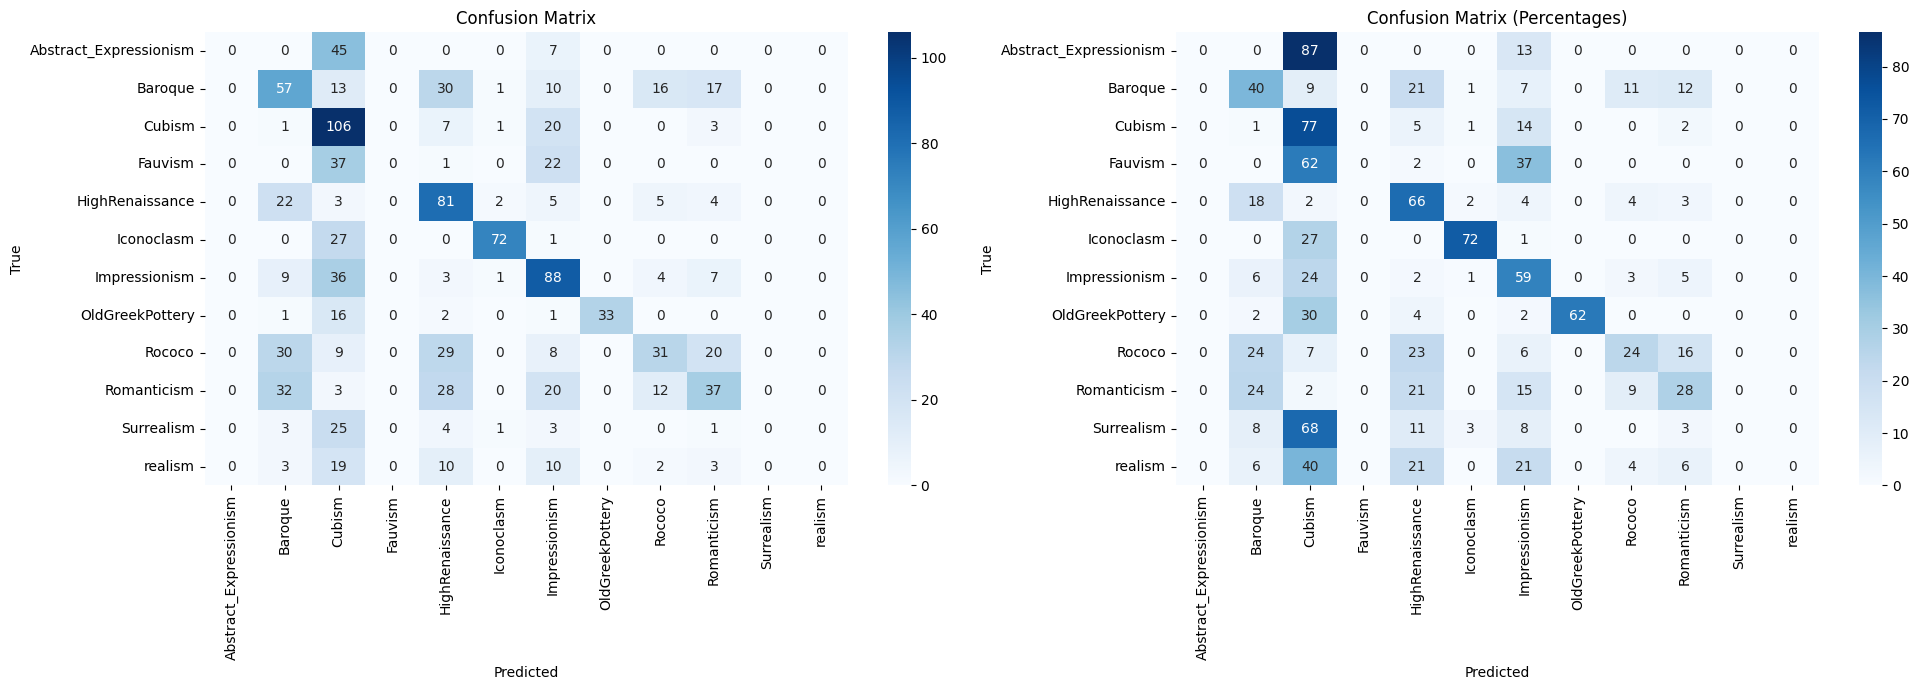

Overall Accuracy: 0.4353
                     Class  Precision  Recall  F1 Score  Accuracy  Support
0   Abstract_Expressionism      0.000   0.000     0.000     0.000     52.0
1                  Baroque      0.361   0.396     0.377     0.396    144.0
2                   Cubism      0.313   0.768     0.444     0.768    138.0
3                  Fauvism      0.000   0.000     0.000     0.000     60.0
4          HighRenaissance      0.415   0.664     0.511     0.664    122.0
5               Iconoclasm      0.923   0.720     0.809     0.720    100.0
6            Impressionism      0.451   0.595     0.513     0.595    148.0
7          OldGreekPottery      1.000   0.623     0.767     0.623     53.0
8                   Rococo      0.443   0.244     0.315     0.244    127.0
9              Romanticism      0.402   0.280     0.330     0.280    132.0
10              Surrealism      0.000   0.000     0.000     0.000     37.0
11                 realism      0.000   0.000     0.000     0.000     47.0


d:\git\FYP\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\git\FYP\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\git\FYP\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


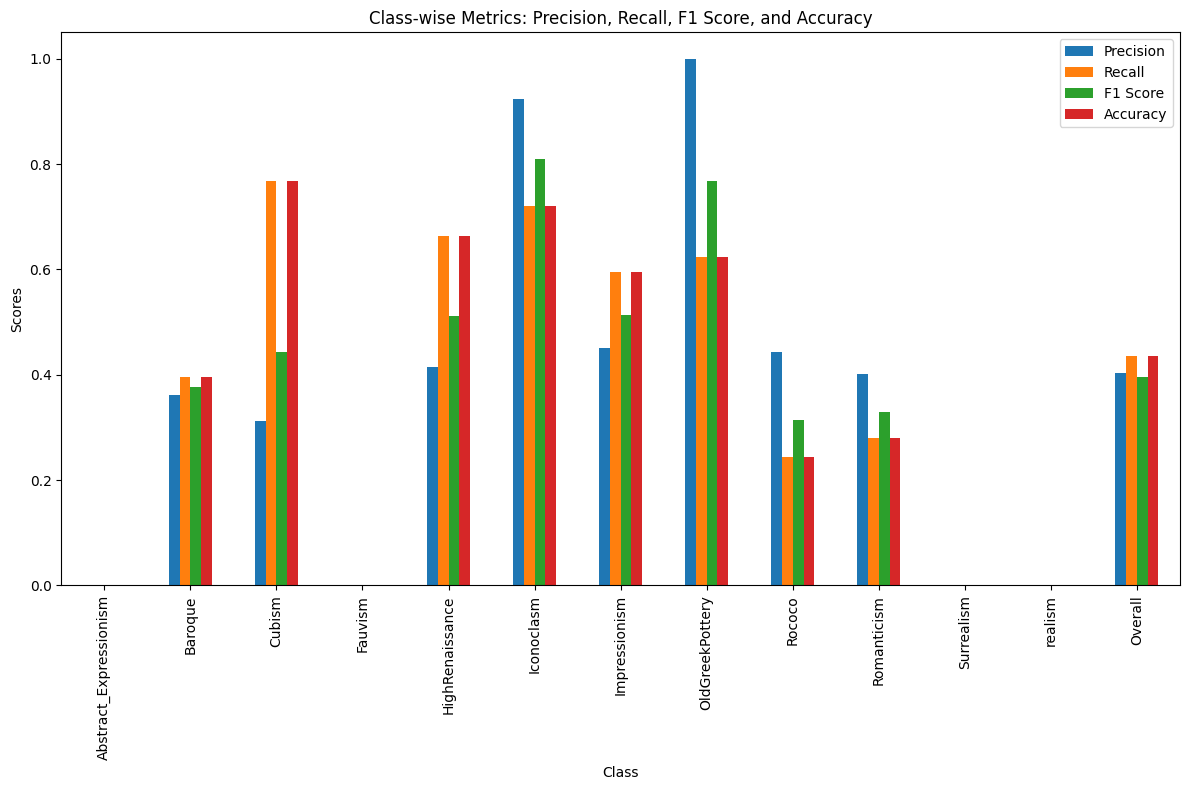

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define transformations for test data
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

datasets_info = [
    # {
    #     "name": "Sample",
    #     "path": r"D:\git\FYP\Python\understanding\sample"
    # },
    {
        "name": "Dataset1",
        "path": r"D:\git\FYP\Python\TwoStage\data\Dataset1\Pandora7k_split_70"
    }
    # {
    #     "name": "Dataset2",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset2\Pandora_18k_split_70"
    # },
    # {
    #     "name": "Dataset3",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset3\Dataset3_Equal_70split"
    # },
    # {
    #     "name": "Dataset4",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset4\BalancedWikiart_70_split"
    # },
    
]


# Load test dataset
#data_dir = "D:/git/FYP/Python/TwoStage/data/Pandora_7k/Pandora7k_split_70"
test_dataset = datasets.ImageFolder(os.path.join(datasets_info[0]['path'], 'test'), test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=4)
class_names = test_dataset.classes

# Load the trained model
#model_path = 'pandora7k_resnet50_80split.pt'
model_path = 'Experiments\\Case_SGD_basic\\Dataset1\\model_Dataset1_SGD_basic.pt'
model = torch.load(model_path)
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Convert to percentage form
# cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# # Plot the percentage confusion matrix
# plt.figure(figsize=(10,7))
# sns.heatmap(cm_percentage, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix (Percentages)')
# plt.show()
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert to percentage form
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a figure with two subplots (side by side)
plt.figure(figsize=(20, 7))

# Plot the confusion matrix (raw values)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Plot the confusion matrix (percentage values)
plt.subplot(1, 2, 2)
sns.heatmap(cm_percentage, annot=True, fmt='.0f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')

# Show both plots side by side
plt.tight_layout()
plt.show()


# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
#print(classification_report(all_labels, all_preds, target_names=class_names))

# Prepare metrics DataFrame with accuracy in a new column next to precision, recall, etc.
metrics = []
for idx, class_name in enumerate(class_names):
    class_metrics = report[class_name]
    class_accuracy = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    metrics.append([
        class_name,
        class_metrics['precision'],
        class_metrics['recall'],
        class_metrics['f1-score'],
        class_accuracy,  # Accuracy added here
        class_metrics['support']
    ])

# Add overall metrics
overall_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_accuracy = accuracy_score(all_labels, all_preds)

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.4f}")

metrics.append([
    'Overall',
    overall_precision,
    overall_recall,
    overall_f1,
    overall_accuracy,  # Overall accuracy added here
    sum(report[class_name]['support'] for class_name in class_names)
])

# Create DataFrame with accuracy next to precision, recall, f1-score, and support
metrics_df = pd.DataFrame(metrics, columns=['Class', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'Support'])

# Round the values to 3 decimal places
metrics_df = metrics_df.round({'Precision': 3, 'Recall': 3, 'F1 Score': 3, 'Accuracy': 3})


# Debugging: Print the DataFrame to ensure accuracy is included
print(metrics_df)

# Excel file path
excel_path = 'Testing Outputs.xlsx'

# Write metrics and confusion matrix to separate sheets
with pd.ExcelWriter(excel_path) as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_excel(writer, sheet_name='Confusion Matrix')

print(f"Classification metrics and confusion matrix saved to {excel_path}")

# Visualization: Bar Plot for Precision, Recall, F1-Score, and Accuracy
metrics_df.set_index('Class')[['Precision', 'Recall', 'F1 Score', 'Accuracy']].plot(kind='bar', figsize=(12, 8))
plt.title('Class-wise Metrics: Precision, Recall, F1 Score, and Accuracy')
plt.ylabel('Scores')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion() 

# Define datasets
datasets_info = [
    # {
    #     "name": "Sample",
    #     "path": r"D:\git\FYP\Python\understanding\sample"
    # },
    # {
    #     "name": "Dataset1",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset1\Pandora7k_split_70"
    # },
    # {
    #     "name": "Dataset2",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset2\Pandora_18k_split_70"
    # },
    # {
    #     "name": "Dataset3",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset3\Dataset3_Equal_70split"
    # },
    # {
    #     "name": "Dataset4",
    #     "path": r"D:\git\FYP\Python\TwoStage\data\Dataset4\BalancedWikiart_70_split"
    # },
    {
        "name": "Dataset5",
        "path": r"D:\git\FYP\Python\TwoStage\data\Dataset5\Dataset5_70_split"
    }
    
]

# Define optimizer and scheduler configurations
configurations = [
    {
        "name": "SGD_basic",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5)
    },
    {
        "name": "SGD_gamma",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    },
    {
        "name": "SGD_momentum_gamma",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    },
    {
        "name": "SGD_momentum_gamma_lr0.0001",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.0001, momentum=0.9),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    },
    {
        "name": "SGD_momentum_gamma_lr0.01",
        "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "scheduler": lambda opt: lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    }
]

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

results = []


# Function to train/validate a model for a single epoch
def run_epoch(model, dataloader, criterion, optimizer=None, scheduler=None, phase='train'):
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities
    image_names = []  # To store image names
    
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() if optimizer else None
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # Store probabilities
        image_names.extend([x[0].split("\\")[-1] for x in dataloader.dataset.samples])
    
    if phase == 'train' and scheduler:
        scheduler.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    return epoch_loss, epoch_acc.item(), precision, recall, f1, image_names, all_labels, all_preds, all_probs

# Function to calculate precision, recall, and F1 scores
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return precision, recall, f1

# Function to handle training and validation across epochs
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=50, patience=5, model_name='best_model.pt'):
    best_acc = 0.0
    epochs_no_improve = 0
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'loss': []}  # Added 'loss' key
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'loss': []}    # Added 'loss' key
    best_epoch = 0
    all_image_data = []
    all_image_probs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n{"-"*10}')
        
        # Training and validation phases
        for phase in ['train', 'val']:
            dataloader = dataloaders[phase]
            optimizer_to_use = optimizer if phase == 'train' else None
            epoch_loss, epoch_acc, precision, recall, f1, image_names, true_labels, pred_labels, probs = run_epoch(
                model, dataloader, criterion, optimizer_to_use, scheduler, phase
            )
            
            # Logging metrics
            if phase == 'train':
                train_metrics['accuracy'].append(epoch_acc)
                train_metrics['precision'].append(precision)
                train_metrics['recall'].append(recall)
                train_metrics['f1'].append(f1)
                train_metrics['loss'].append(epoch_loss)  # Store the loss value
            else:
                val_metrics['accuracy'].append(epoch_acc)
                val_metrics['precision'].append(precision)
                val_metrics['recall'].append(recall)
                val_metrics['f1'].append(f1)
                val_metrics['loss'].append(epoch_loss)    # Store the loss value
                
                # Track best accuracy and corresponding epoch
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch + 1
                    print(f"New best accuracy: {best_acc:.4f} at epoch {best_epoch}")

                    epochs_no_improve = 0
                    print(f"New best model found at epoch {best_epoch}, saving the entire model.")
                    torch.save(model, model_name)
                    
                    # Store validation results for best model
                    all_image_data = list(zip(image_names, true_labels, pred_labels))
                    all_image_probs = probs
                else:
                    epochs_no_improve += 1
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                    f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
        
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
        print()
    
    # Load the best saved model
    if os.path.exists(model_name):
        model = torch.load(model_name)
        print(f"Best model loaded from {model_name}.")
    else:
        print("No model saved; returning the last trained model.")
    return model, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc
    return model, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc


# Function to output metrics as a DataFrame
def metrics_to_df(train_metrics, val_metrics, best_epoch):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    metrics_df = pd.DataFrame({
        'Epoch': epochs,
        'Train Loss': train_metrics['loss'],
        'Val Loss': val_metrics['loss'],
        'Train Accuracy': train_metrics['accuracy'],
        'Val Accuracy': val_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Val Precision': val_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Val Recall': val_metrics['recall'],
        'Train F1 Score': train_metrics['f1'],
        'Val F1 Score': val_metrics['f1'],
    })
    metrics_df['Best Epoch'] = best_epoch
    return metrics_df


import xlsxwriter
#Function to save predictions to Excel with class names instead of numerical labels
def save_predictions_to_excel(all_image_data, all_probs, metrics_df, class_names, folder_name='.', filename='model_output.xlsx'):
    # Map numerical class labels to class names
    rows = []
    
    for (image_name, true_class, pred_class), probs in zip(all_image_data, all_probs):
        # Get top 3 predictions and their probabilities
        top3_indices = np.argsort(probs)[::-1][:3]
        top3_classes = [class_names[idx] for idx in top3_indices]
        top3_probs = [probs[idx] for idx in top3_indices]
        
        row = {
            'Image Name': image_name,
            'True Class': class_names[true_class],
            'Predicted Class': class_names[pred_class],
            'Correct Prediction': class_names[true_class] == class_names[pred_class],
            'Top1 Class': top3_classes[0],
            'Top1 Probability': f"{top3_probs[0]:.4f}",
            'Top2 Class': top3_classes[1],
            'Top2 Probability': f"{top3_probs[1]:.4f}",
            'Top3 Class': top3_classes[2],
            'Top3 Probability': f"{top3_probs[2]:.4f}"
        }
        rows.append(row)
    
    predictions_df = pd.DataFrame(rows)
    
    # Create full path for the file
    full_path = os.path.join(folder_name, os.path.basename(filename))
    
    with pd.ExcelWriter(full_path, engine='xlsxwriter') as writer:
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    print(f"Predictions and metrics saved to {full_path}.")

# Define function to create the folder structure
def create_folder_structure(base_dir="Experiments"):
    # Create base directory
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        print(f"Created base directory: {base_dir}")
    
    # Create case directories and subdirectories
    for config in configurations:
        case_dir = os.path.join(base_dir, f"Case_{config['name']}")
        if not os.path.exists(case_dir):
            os.makedirs(case_dir)
            print(f"Created case directory: {case_dir}")
        
        # Create dataset subdirectories
        for dataset in datasets_info:
            dataset_dir = os.path.join(case_dir, dataset["name"])
            validation_dir = os.path.join(dataset_dir, "Validation")
            testing_dir = os.path.join(dataset_dir, "Testing")
            
            for dir_path in [dataset_dir, validation_dir, testing_dir]:
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                    print(f"Created directory: {dir_path}")
    
    return base_dir

def plot_metrics_and_save(train_metrics, val_metrics, output_dir, filename_prefix='metrics'):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    
    # Create a figure with a 3x2 grid of subplots to include loss
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    
    # Plot Accuracy
    axes[0, 0].plot(epochs, train_metrics['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(epochs, val_metrics['accuracy'], label='Validation Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].set_title('Accuracy over Epochs')
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Precision
    axes[0, 1].plot(epochs, train_metrics['precision'], label='Train Precision')
    axes[0, 1].plot(epochs, val_metrics['precision'], label='Validation Precision')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()
    axes[0, 1].set_title('Precision over Epochs')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Recall
    axes[1, 0].plot(epochs, train_metrics['recall'], label='Train Recall')
    axes[1, 0].plot(epochs, val_metrics['recall'], label='Validation Recall')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].set_title('Recall over Epochs')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot F1 Score
    axes[1, 1].plot(epochs, train_metrics['f1'], label='Train F1 Score')
    axes[1, 1].plot(epochs, val_metrics['f1'], label='Validation F1 Score')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].set_title('F1 Score over Epochs')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

     # Plot Loss
    if 'loss' in train_metrics and 'loss' in val_metrics:
        axes[2, 0].plot(epochs, train_metrics['loss'], label='Train Loss')
        axes[2, 0].plot(epochs, val_metrics['loss'], label='Validation Loss')
        axes[2, 0].set_xlabel('Epochs')
        axes[2, 0].set_ylabel('Loss')
        axes[2, 0].legend()
        axes[2, 0].set_title('Loss over Epochs')
        axes[2, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove the extra subplot
    fig.delaxes(axes[2, 1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "all_metrics.png"))
    plt.show()
    
    # Also create a separate loss plot with appropriate scale
    if 'loss' in train_metrics and 'loss' in val_metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "loss_plot.png"))
        plt.show()
# Function to calculate and plot the confusion matrix
#in next run, addeth confusion matrix to A SHEET IN THE EXCEL FILE
def plot_confusion_matrix(model, dataloader, class_names, output_dir):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    #plt.figure(figsize=(10, 8))
    plt.figure(figsize=(14, 14))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.show()


def plot_per_class_metrics(model, dataloader, class_names, output_dir):
    """
    Generate and save a combined bar graph showing accuracy, precision, recall, and F1 score per class.
    
    Args:
        model: Trained model
        dataloader: Validation data loader
        class_names: List of class names
        output_dir: Directory to save the plots
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics per class
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    # Calculate accuracy per class
    accuracy_per_class = []
    for i in range(len(class_names)):
        class_mask = (all_labels == i)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            accuracy_per_class.append(np.mean(all_preds[class_mask] == all_labels[class_mask]))
        else:
            accuracy_per_class.append(0)
    
    # Create DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Create a single combined bar chart
    plt.figure(figsize=(14, 10))
    metrics_df.set_index('Class')[['Precision', 'Recall', 'F1 Score', 'Accuracy']].plot(
        kind='bar', 
        figsize=(14, 10),
        #color=['lightgreen', 'salmon', 'mediumpurple', 'skyblue']
    )
    plt.title('Class-wise Metrics: Precision, Recall, F1 Score, and Accuracy', fontsize=16)
    plt.ylabel('Scores', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(output_dir, "per_class_metrics.png"), bbox_inches='tight')
    plt.show()
    
    # Also create individual bar charts for better comparison (optional)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot accuracy
    axes[0, 0].bar(class_names, accuracy_per_class)
    axes[0, 0].set_title('Accuracy per Class')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot precision
    axes[0, 1].bar(class_names, precision)
    axes[0, 1].set_title('Precision per Class')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot recall
    axes[1, 0].bar(class_names, recall)
    axes[1, 0].set_title('Recall per Class')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=90)
    
    # Plot F1 score
    axes[1, 1].bar(class_names, f1)
    axes[1, 1].set_title('F1 Score per Class')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "per_class_metrics_individual.png"), bbox_inches='tight')
    plt.show()
    
    # Save the metrics as CSV for further analysis
    metrics_df.to_csv(os.path.join(output_dir, "per_class_metrics.csv"), index=False)
    print(f"Per-class metrics saved to {os.path.join(output_dir, 'per_class_metrics.csv')}")


base_dir = create_folder_structure("Experiments")
all_experiments = []

# Loop through datasets
for dataset_info in datasets_info:
    data_dir = dataset_info["path"]
    dataset_name = dataset_info["name"]
    
    print(f"\nProcessing dataset: {dataset_name} from {data_dir}")
    
    # Setup data for this dataset
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['train', 'val']}
    dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    # Loop through optimizer/scheduler configurations
    for config in configurations:
        config_name = config["name"]
        print(f"\nTraining with configuration: {config_name}")
        
        # Define paths for this experiment
        case_dir = os.path.join(base_dir, f"Case_{config_name}")
        dataset_dir = os.path.join(case_dir, dataset_name)
        validation_dir = os.path.join(dataset_dir, "Validation")
        testing_dir = os.path.join(dataset_dir, "Testing")
        
        model_name = os.path.join(dataset_dir, f"model_{dataset_name}_{config_name}.pt")
        excel_file = os.path.join(validation_dir, "predictions.xlsx")
        summary_file = os.path.join(case_dir, "summary.xlsx")
        
        # Initialize model
        model_ft = models.resnet50(weights='IMAGENET1K_V1')
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, len(class_names))
        model_ft = model_ft.to(device)
        
        # Set criterion
        criterion = nn.CrossEntropyLoss()
        
        # Create optimizer and scheduler for this configuration
        optimizer_ft = config["optimizer"](model_ft)
        exp_lr_scheduler = config["scheduler"](optimizer_ft)
        
        # Train model with this configuration
        model_ft, train_metrics, val_metrics, all_image_data, all_image_probs, class_names, best_epoch, best_acc = train_model(
            model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
            num_epochs=50, patience=5, model_name=model_name
        )

        
        # Convert metrics to DataFrame
        metrics_df = metrics_to_df(train_metrics, val_metrics, best_epoch)
        metrics_df['Best Accuracy'] = best_acc
        metrics_df['Best Epoch'] = best_epoch
        
        # Save metrics to CSV in validation folder
        metrics_df.to_csv(os.path.join(validation_dir, "metrics.csv"), index=False)
        
        # Save predictions to Excel
        save_predictions_to_excel(all_image_data, all_image_probs, metrics_df, class_names, 
                          folder_name=validation_dir, filename=excel_file)
        
        plot_metrics_and_save(train_metrics, val_metrics, validation_dir)

        plot_confusion_matrix(model_ft, dataloaders['val'], class_names, validation_dir)

        
        # Add this line to generate and save per-class metrics
        plot_per_class_metrics(model_ft, dataloaders['val'], class_names, validation_dir)    

        # Store summary information for this experiment
        experiment_summary = {
            'Dataset': dataset_name,
            'Configuration': config_name,
            'Best Epoch': best_epoch,
            'Best Validation Accuracy': best_acc,
            'Final Train Accuracy': train_metrics['accuracy'][-1],
            'Final Train Precision': train_metrics['precision'][-1],
            'Final Train Recall': train_metrics['recall'][-1],
            'Final Train F1': train_metrics['f1'][-1],
            'Final Validation Accuracy': val_metrics['accuracy'][-1],
            'Final Validation Precision': val_metrics['precision'][-1],
            'Final Validation Recall': val_metrics['recall'][-1],
            'Final Validation F1': val_metrics['f1'][-1],
            'Model Path': model_name
        }
        all_experiments.append(experiment_summary)
        
        # Save case-specific summary
        case_experiments = [exp for exp in all_experiments if exp['Configuration'] == config_name]
        case_summary_df = pd.DataFrame(case_experiments)
        case_summary_df.to_excel(summary_file, index=False)

# Create and save summary of all experiments
summary_df = pd.DataFrame(all_experiments)
summary_df.to_excel(os.path.join(base_dir, "all_experiments_summary.xlsx"), index=False)

print(f"\nAll experiment results have been summarized in {os.path.join(base_dir, 'all_experiments_summary.xlsx')}")









In [ ]:
import os
from PIL import Image
from tqdm import tqdm  # Progress bar

# Path to the dataset
dataset_path = r"D:\git\FYP\Python\TwoStage\data\Dataset5\Dataset5_70_split"

# Log file to store corrupt images
log_file = os.path.join(dataset_path, "corrupt_images_log.txt")

# Function to check images
def check_and_remove_corrupt_images(root_folder):
    corrupt_images = []
    all_images = []

    # Collect all image paths first
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            all_images.append((subdir, file))

    print(f"Scanning {len(all_images)} images...\n")

    # Process images with a progress bar
    for subdir, file in tqdm(all_images, desc="Checking images", unit="img"):
        file_path = os.path.join(subdir, file)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Check if image is corrupted
        except Exception as e:
            corrupt_images.append((file, subdir))
            os.remove(file_path)  # Delete the corrupt file
            print(f"\nRemoved corrupt image: {file} in {subdir} | Error: {e}")

    # Save log
    if corrupt_images:
        with open(log_file, "w") as f:
            for img, folder in corrupt_images:
                f.write(f"{img} in {folder}\n")
        print(f"\nScan complete. Removed {len(corrupt_images)} corrupt images. Log saved at {log_file}")
    else:
        print("\nScan complete. No corrupt images found!")

# Run the check
check_and_remove_corrupt_images(dataset_path)


In [ ]:
import os
from PIL import Image
from tqdm import tqdm  

# Path to dataset
dataset_path = r"D:\git\FYP\Python\TwoStage\data\Dataset5\Dataset5_70_split"

# Log file
log_file = os.path.join(dataset_path, "corrupt_or_large_images_log.txt")

# Maximum allowed pixels
MAX_PIXELS = 89478485  

# Function to check and resize large images
def check_and_fix_images(root_folder):
    problem_images = []
    all_images = []

    # Collect all image paths
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            all_images.append((subdir, file))

    print(f"Scanning {len(all_images)} images...\n")

    # Process images with progress bar
    for subdir, file in tqdm(all_images, desc="Checking images", unit="img"):
        file_path = os.path.join(subdir, file)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Check if corrupted

                # Check if image is too large
                img = Image.open(file_path)
                if img.width * img.height > MAX_PIXELS:
                    print(f"\nResizing large image: {file} in {subdir}")
                    problem_images.append((file, subdir, "Large Image"))

                    # Resize the image
                    img.thumbnail((2000, 2000))  # Resize to a max dimension
                    img.save(file_path)  # Overwrite the image

        except Exception as e:
            problem_images.append((file, subdir, "Corrupt"))
            os.remove(file_path)  # Remove corrupt files
            print(f"\nRemoved corrupt image: {file} in {subdir} | Error: {e}")

    # Save log
    if problem_images:
        with open(log_file, "w") as f:
            for img, folder, issue in problem_images:
                f.write(f"{img} in {folder} | Issue: {issue}\n")
        print(f"\nScan complete. Fixed {len(problem_images)} images. Log saved at {log_file}")
    else:
        print("\nScan complete. No corrupt or oversized images found!")

# Run the check
check_and_fix_images(dataset_path)
